In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np

from pyaml.accelerator import Accelerator
from pyaml.common.constants import ACTION_MEASURE
from pyaml.magnet.magnet import Magnet

### Virtual accelerator setup for emulation of a control system
For the **live** control mode, you should have some control system emulation running. 

!!! *If you want to skip this, you can always run the notebook in **design** mode.* !!!

For the installation you should be able to do 
```
apptainer pull virtual-accelerator.sif oras://gitlab-registry.synchrotron-soleil.fr/software-control-system/containers/apptainer/virtual-accelerator:latest
apptainer run virtual-accelerator.sif
```
This will run SOLEIL II proof-of-concept digital twin on localhost:11000. You can play with the digital twin itself (without pyAML) via Jive to check that everything is working. You can run Jive in a different terminal with 
```
apptainer pull jive.sif https://gitlab.synchrotron-soleil.fr/api/v4/projects/2739/packages/generic/jive/latest/jive.sif
apptainer run jive.sif
```
On linux you may additionally configure X11
```
export DISPLAY=:0
xhost +local:root
```
Jive is not necessary to run anything but some of you may find it useful to open its `simulator/ringsimulator/ringsimulator` device on the side and see how the global parameters (tune, orbit, chromaticity, etc.) change with your actions in pyAML.
NOTE: This notebook is just a demonstration of pyAML functionality. Certain things may be done stupidly. The person who wrote this jupyter notebook only cared about showing that the code is working, not about intelligently controlling the accelerator.

In [7]:
sr = Accelerator.load("p.yaml")
sr  # string representation

06 Feb% 2026, 20:53:26 | WARNING | PyAML Tango control system binding (0.3.3) initialized with name 'live' and TANGO_HOST=localhost:11000


### Control mode choice
You can choose either sr.live control mode or sr.design control mode
- **sr.live** is intended for use with control system either digital twin or a real accelerator
- **sr.design** will just run pyAT without any control system 
     
In this notebook with **sr.design** you can put all wait times to zero or some negligible value. In **sr.live** mode, a wait time of 1.5 seconds is necessary becausethe  digital twin is updating every 0.5-1 second.

In [9]:
control_mode = sr.live
wait_time = 0 if control_mode == sr.design else 1.5
control_mode  # string representation

TangoControlSystem(name='live', tango_host='localhost:11000', debug_level=None, lazy_devices=True, scalar_aggregator='tango.pyaml.multi_attribute', vector_aggregator=None, timeout_ms=3000)

#### Accessing betatron tune monitor / diagnostics
Betatron tune monitor object is already defined near the end of the configuration file with a name "BETATRON_TUNE".

In [13]:
tune_monitor = control_mode.get_betatron_tune_monitor("BETATRON_TUNE")
print(tune_monitor.tune.get())
tune_monitor  # string representation

[0.20136665 0.30000589]


BetatronTuneMonitor(peer='TangoControlSystem:live', name='BETATRON_TUNE', description=None, lattice_names=None, tune_h=AttributeReadOnly(attribute='simulator/ringsimulator/ringsimulator/Tune_h', unit='', range=None), tune_v=AttributeReadOnly(attribute='simulator/ringsimulator/ringsimulator/Tune_v', unit='', range=None))

#### Accessing quadrupolar correctors available in the ring
The configuration file already has a "QCORR" array of magnets defined. get_magnets() method will return a list of magnets. In this notebook we will control each of the correctors individually. 

In [14]:
qcorrectors = control_mode.get_magnets("QCORR")
first_qcorrector = qcorrectors[0]
print(
    f"The ring has {len(qcorrectors)} quadrupolar correctors. "
    f"The first one is named {first_qcorrector.get_name()} (lattice name)."
)
qcorrectors[0]  # String representation of the first corrector

The ring has 208 quadrupolar correctors. The first one is named QCORR_001 (lattice name).


Quadrupole(peer='TangoControlSystem:live', name='QCORR_001', model_name='QCORR_001', magnet_model=IdentityMagnetModel(powerconverter=None, physics=Attribute(attribute='AN01-AR/EM-COR/CQLN.03/strength', unit='1/m', range=None), unit='1/m'))

In [19]:
print(
    f"We can access the strength of the corrector {qcorrectors[0].strength.get()=:.2f},"
    f"we can set it to some value with qcorrectors[0].strength.set(0.2)"
)
qcorrectors[0].strength.set(0.2)
print(
    f"Let's check that the readback is what "
    f"we asked for {qcorrectors[0].strength.get()=:.2f}, "
)
qcorrectors[0].strength.set(0)  # setting back to original value

We can access the strength of the corrector qcorrectors[0].strength.get()=0.00, we can set it to some value with qcorrectors[0].strength.set(0.2)
Let's check that the readback is what we asked for qcorrectors[0].strength.get()=0.20, 


### Standard tuning tool for tune correction
The standard tuning tool for tune correction can be accessed by name "DEFAULT_TUNE_CORRECTION". At the same time, this default tune correction can be accessed as a property of a control mode.

In [21]:
tune_correction = control_mode.get_tune_tuning("DEFAULT_TUNE_CORRECTION")

control_mode.tune, tune_correction  # string representation

(Tune(peer='TangoControlSystem:live', name='DEFAULT_TUNE_CORRECTION', description=None, lattice_names=None, quad_array='QCORR', betatron_tune='BETATRON_TUNE', delta=0.001),
 Tune(peer='TangoControlSystem:live', name='DEFAULT_TUNE_CORRECTION', description=None, lattice_names=None, quad_array='QCORR', betatron_tune='BETATRON_TUNE', delta=0.001))

Let's try to set the tune using the tune correction tool. This will not be possible because no response matrix is defined at the moment. The response matrix can either be loaded from a file or measured. You can also measure the response matrix in **design** mode and try to use in in **live** mode.

In [22]:
from pyaml import PyAMLException

try:
    tune_correction.set([0.21, 0.31])
except PyAMLException as e:
    print(
        f"We've got an exception (this is intended) throwing the following error: {e}"
    )

We've got an exception (this is intended) throwing the following error: TuneResponse.correct(): no matrix loaded or measured


It is not possible to do so without measuring the response matrix (or loading it from a file). In the properties of the tune_correction, we can find a TuneResponse object with a measure() method. However, before doing that, we can define a callback that will print progress during the measurement. The measurement will take a while because of the 1.5-second wait time necessary to get a response from the virtual accelerator. You can try to change this and see what the minimal response time is for your hardware.

In [23]:
def tune_callback(step: int, action: int, m: Magnet, dtune: np.array):
    if action == ACTION_MEASURE:
        # On action measure, the measured dq / dk is passed as argument
        print(f"Tune response: #{step} {m.get_name()}")
    return True

In [24]:
%%time
tune_correction.response.measure(callback=tune_callback, set_wait_time=1.5)

Tune response: #0 QCORR_001
Tune response: #1 QCORR_002
Tune response: #2 QCORR_003
Tune response: #3 QCORR_004
Tune response: #4 QCORR_005
Tune response: #5 QCORR_006
Tune response: #6 QCORR_007
Tune response: #7 QCORR_008
Tune response: #8 QCORR_009
Tune response: #9 QCORR_010
Tune response: #10 QCORR_011
Tune response: #11 QCORR_012
Tune response: #12 QCORR_013
Tune response: #13 QCORR_014
Tune response: #14 QCORR_015
Tune response: #15 QCORR_016
Tune response: #16 QCORR_017
Tune response: #17 QCORR_018
Tune response: #18 QCORR_019
Tune response: #19 QCORR_020
Tune response: #20 QCORR_021
Tune response: #21 QCORR_022
Tune response: #22 QCORR_023
Tune response: #23 QCORR_024
Tune response: #24 QCORR_025
Tune response: #25 QCORR_026
Tune response: #26 QCORR_027
Tune response: #27 QCORR_028
Tune response: #28 QCORR_029
Tune response: #29 QCORR_030
Tune response: #30 QCORR_031
Tune response: #31 QCORR_032
Tune response: #32 QCORR_033
Tune response: #33 QCORR_034
Tune response: #34 QCORR

The correction matrix can be saved to a file (and added to the configuration file).
```
tune_correction.response.save_json("tune_response_matrix_live.json")
tune_correction.response.load_json('tune_response_matrix_design.json')
```

In [28]:
tune_correction.set([0.21, 0.31], iter=10, wait_time=1.2)

In [30]:
print(
    f"Readback after changing tune is {tune_correction.readback()}. "
    f"We can also check the setpoint {tune_monitor.tune.get()}"
)
tune_correction  # string representation

Readback after changing tune is [0.20998987 0.30996522]. We can also check the setpoint [0.20998987 0.30996522]


Tune(peer='TangoControlSystem:live', name='DEFAULT_TUNE_CORRECTION', description=None, lattice_names=None, quad_array='QCORR', betatron_tune='BETATRON_TUNE', delta=0.001)

In [31]:
print(f"Tune readback is {tune_correction.readback()}")
qx, qy = 0.19, 0.28
print(f"Let's change the tune to {qx=:}, {qy=:}")
tune_correction.set([qx, qy], iter=10, wait_time=1.2)
print(f"Tune readback is {tune_correction.readback()}")

qx, qy = 0.21, 0.3
print(f"Let's change the tune to {qx=:}, {qy=:}")

tune_correction.set([qx, qy], iter=10, wait_time=1.2)
print(f"Tune readback is {tune_correction.readback()}")

# You can try to do something stupid too!
# qx, qy = 0.5, 0.0
# print(f"Let's do something stupid and change the tune to {qx=:}, {qy=:}")
# tune_correction.set([qx, qy])

Tune readback is [0.20998987 0.30996522]
Let's change the tune to qx=0.19, qy=0.28
Tune readback is [0.18978154 0.26066936]
Let's change the tune to qx=0.21, qy=0.3
Tune readback is [0.20384987 0.34325573]


### Manual tune correction
We can also do everything manually in case there are no tuning tool available or you are developing/modifying one.

In [32]:
control_mode = sr.live
qcorrectors = control_mode.get_magnets("QCORR")
tune_monitor = control_mode.get_betatron_tune_monitor("BETATRON_TUNE")

In [33]:
tunemat = np.zeros((len(qcorrectors), 2))
design_tune = tune_monitor.tune.get()
print(f"Design tune is {design_tune}")
print(f"Tune in live mode is {tune_monitor.tune.get()}")

Design tune is [0.22256749 0.25918036]
Tune in live mode is [0.22256749 0.25918036]


In [34]:
from time import sleep

from tqdm.notebook import tqdm

# You can remove tqdm import and tqdm from enumerate
# It only provides a progress bar for for-loop

for idx, m in enumerate(tqdm(qcorrectors)):
    strength = m.strength.get()
    delta = 1e-3
    m.strength.set(strength + delta)
    sleep(1)
    dq = tune_monitor.tune.get() - design_tune
    tunemat[idx] = dq / delta
    m.strength.set(strength)

# Compute correction matrix
correctionmat = np.linalg.pinv(tunemat.T)

  0%|          | 0/208 [00:00<?, ?it/s]

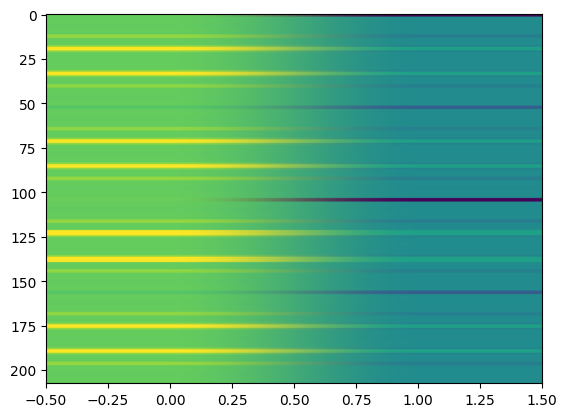

In [35]:
plt.imshow(tunemat, aspect="auto")

In [36]:
old_strength_values = qcorrectors.strengths.get()
print(f"Tune before correction {tune_monitor.tune.get()}")
dqx, dqy = -0.01, -0.02
print(f"Chanding tune by [{dqx}, {dqy}]")
new_strength = old_strength_values + np.matmul(correctionmat, [dqx, dqy])
qcorrectors.strengths.set(new_strength)
sleep(2)
# tune_monitor.tune.get()
print(f"Tune after correction {tune_monitor.tune.get()}")
qcorrectors.strengths.set(old_strength_values)
sleep(3)
print(
    f"Tune setting the tune back to original value correction {tune_monitor.tune.get()}"
)

Tune before correction [0.22270859 0.25805266]
Chanding tune by [-0.01, -0.02]
Tune after correction [0.22256749 0.25918036]
Tune setting the tune back to original value correction [0.22256749 0.25918036]
